In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [33]:
L"x_{|| max}"

L"$x_{|| max}$"

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [4]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 300000.0)

(0.0, 300000.0)

In [25]:
k_space = range(0.050, 0.056, step = 0.0001)
length(k_space)

61

In [26]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)

int (generic function with 1 method)

In [27]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.0

In [28]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k, k, 0]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: 0.05
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.05, 0.0]
Spectrum: [2.2325970710086216e-5, -0.000473287098659713, -0.009275153672171962, -0.02562594481113444, -7.356802126040773, -10.242162058102076]
Last point: [-1.1346280549661925, -5.234987851453088, 4.105262956414043, -1.0247484954137605, -4.057989084441211, 4.187757055167532]
x_sum before truncate length: 3782002
x_sum after truncate length: 1891002
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1346280549661925, -5.234987851453088, 4.105262956414043, -1.0247484954137605, -4.057989084441211, 4.187757055167532]
index: 2
k: 0.0501
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0501, 0.0501, 0.0]
Spectrum: [3.234456102331897e-6, -0.0004469672730044421, -0.009239980706299562, -0.025649464579634983, -7.357931059878366, -10.24432592058698]
Last point: [-0.7931797831014801, -2.3338806209944063, 4.025175615667694, -0.9406136792372749, -3.4438830270110

Last point: [-1.2151586172389037, -6.501830800998964, 3.7108254934688474, -1.2414425114227488, -6.714275934773815, 3.820317054251586]
x_sum before truncate length: 3786834
x_sum after truncate length: 1893418
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.2151586172389037, -6.501830800998964, 3.7108254934688474, -1.2414425114227488, -6.714275934773815, 3.820317054251586]
index: 15
k: 0.0514
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0514, 0.0514, 0.0]
Spectrum: [4.411401805467228e-6, -0.00011905235777033092, -0.008591108061171537, -0.025647834690557317, -7.371489499389306, -10.23486579390058]
Last point: [-0.13302694368505838, 0.0447065078684144, 3.6459437552843332, -0.8791897241113638, -3.428927053534344, 3.596071026183911]
x_sum before truncate length: 3788065
x_sum after truncate length: 1894034
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.13302694368505838, 0.0447065078684144, 3.6459437552843332, -0.8791897241113638, -3.428927053534344, 3.596071026183911]
index: 1

index: 28
k: 0.0527
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0527, 0.0527, 0.0]
Spectrum: [2.1829925668460646e-5, -0.0003926020912685779, -0.008205404158340179, -0.03328068417794225, -7.400134540988138, -10.197528756515183]
Last point: [-1.163981602396483, -5.946758048138285, 3.6780713592580394, -1.2383703598026898, -6.71623147247044, 3.778061679459443]
x_sum before truncate length: 3780270
x_sum after truncate length: 1890136
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.163981602396483, -5.946758048138285, 3.6780713592580394, -1.2383703598026898, -6.71623147247044, 3.778061679459443]
index: 29
k: 0.0528
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0528, 0.0528, 0.0]
Spectrum: [1.6538903310331063e-5, -0.00042784078417953914, -0.008234704491454217, -0.0363735580858079, -7.401083863022635, -10.192435607528468]
Last point: [-1.0056724323187292, -4.437074442827709, 3.5723221137657557, -1.1042946781154543, -5.33915952945832, 3.641636968165293]
x_sum before truncate 

Last point: [-1.154475255971909, -5.4769383072003555, 4.075743113287583, -1.221437461294384, -6.341403294456751, 3.9649948002872244]
x_sum before truncate length: 3686469
x_sum after truncate length: 1843236
counts: 62
>>>>>>>>>>>>>>>

Initial condition: [-1.154475255971909, -5.4769383072003555, 4.075743113287583, -1.221437461294384, -6.341403294456751, 3.9649948002872244]
index: 42
k: 0.0541
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0541, 0.0541, 0.0]
Spectrum: [0.009954208472815291, 0.0032407035188323024, -0.001137783549207359, -0.009089234349527001, -7.2468283440887715, -10.149219380449635]
Last point: [-0.9711334966521273, -3.9827242455409464, 3.7315391875676163, -1.0252046582014065, -4.121401053992115, 4.122453821086548]
x_sum before truncate length: 3689145
x_sum after truncate length: 1844574
counts: 84
>>>>>>>>>>>>>>>

Initial condition: [-0.9711334966521273, -3.9827242455409464, 3.7315391875676163, -1.0252046582014065, -4.121401053992115, 4.122453821086548]
index: 4

Initial condition: [-0.5695427753527708, -1.2160792227160697, 3.820275129055579, -0.8795798185064614, -3.14376786250699, 3.827573912996544]
index: 55
k: 0.0554
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0554, 0.0554, 0.0]
Spectrum: [0.01071236805583404, 0.0036659973993292887, -0.00047471665088946643, -0.007825733943412055, -7.2170367532868624, -10.160467760311633]
Last point: [-0.900420566713679, -3.1434957984374403, 4.007016517666282, -1.0906717307122986, -4.914949860582423, 3.953393102890681]
x_sum before truncate length: 3668432
x_sum after truncate length: 1834217
counts: 86
>>>>>>>>>>>>>>>

Initial condition: [-0.900420566713679, -3.1434957984374403, 4.007016517666282, -1.0906717307122986, -4.914949860582423, 3.953393102890681]
index: 56
k: 0.0555
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0555, 0.0555, 0.0]
Spectrum: [0.010197486712261682, 0.003680875223681427, -0.0008388861944383689, -0.00880825231657843, -7.233051784461679, -10.156099203867912]
Last point: [

In [9]:
using CairoMakie

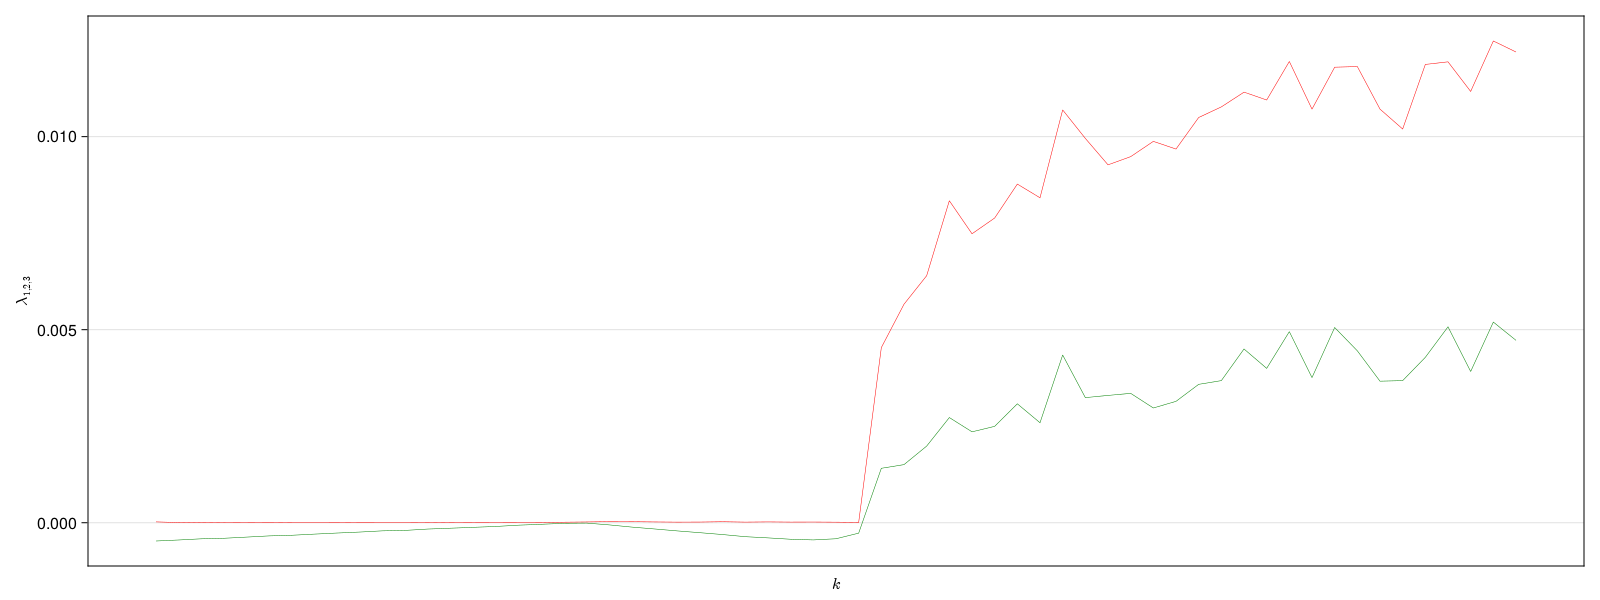

In [31]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, spectrum_array[1, :], linewidth = 0.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 0.5, color = "green")
#lines!(ax, k_space, spectrum_array[3, :], linewidth = 0.5, color = "blue")
f

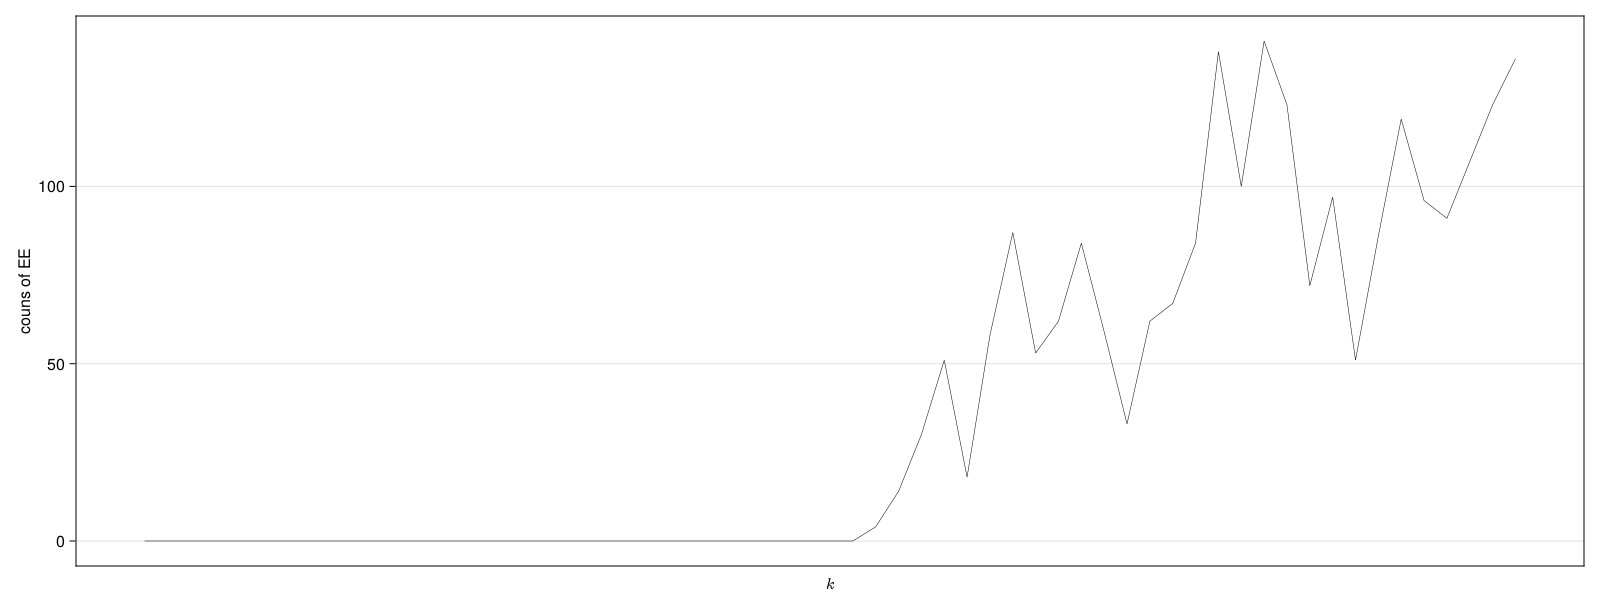

In [30]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = "couns of EE")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, EVA_array, linewidth = 0.5, color = "black")

f